# Notebook Objective - Model Interpretability
Finally it is necessary to explain the ways in which the models work. For this we apply a Saliency Map and GradCAM visualisation to the model weights

In [1]:
import numpy as np
import os
import cv2
import random
import tensorflow as tf

from tensorflow import newaxis, GradientTape, argmax, reduce_mean, squeeze
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.utils import load_img, img_to_array, array_to_img

# Display
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm

## Saliency Maps

### Utility Functions
- pick_random_image: Picks a random image according to albel and case and returns the path as well as the labe
- prep_input: Prepares the image such that it is return as a rescaled and resized image
- norm_flat_image: cenetrs and flattens the gradients of the image
- plot_maps: Do the visualisation

In [2]:
def pick_random_image(label=None, case='raw'):
    '''
    label needs to be one of the 4 labels according to the names of the subfolders
    case needs to be "raw" or "roi", according to the folder structure of the data/preprocessed directory
    '''
    labels = ['COVID', 'Viral Pneumonia', 'Normal', 'Lung_Opacity']
    label = label or random.choice(labels)
    label_dir = os.path.join(base_dir, 'data', 'preprocessed', case, label)
    files = os.listdir(label_dir)
    file = random.choice(files)
    return os.path.join(label_dir, file), label

def prep_input(path):
    image = tf.image.decode_png(tf.io.read_file(path))
    image = tf.expand_dims(image, axis=0)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [256, 256])
    image = image*1./256
    return image

def norm_flat_image(img):
    grads_norm = img[:,:,0]
    grads_norm = (grads_norm - tf.reduce_min(grads_norm))/ (tf.reduce_max(grads_norm)- tf.reduce_min(grads_norm))
    return grads_norm

def plot_maps(img1, img2, vmin=0.3, vmax=0.7, mix_val=2, label='no label'):
    f = plt.figure(figsize=(15, 15))
    plt.subplot(1, 3,1)
    plt.imshow(img1,vmin=vmin, vmax=vmax, cmap="gray")
    plt.yticks([])
    plt.xticks([])
    plt.ylabel(label)
    plt.subplot(1, 3,2)
    plt.imshow(img2, cmap = "gray")
    plt.axis("off")
    plt.subplot(1, 3,3)
    plt.imshow(img1*mix_val+img2/mix_val, cmap = "gray" )
    plt.axis("off")

In [3]:
base_dir = os.path.abspath('..')
# specifiy the model for which the visualisation shall happen
model = load_model(os.path.join(base_dir, 'models', 'cnn', 'LMAP3_nap', 'LMAP3_nap_roi.keras'))

### Visualisation

1/1 [==============================] - 0s 12ms/step


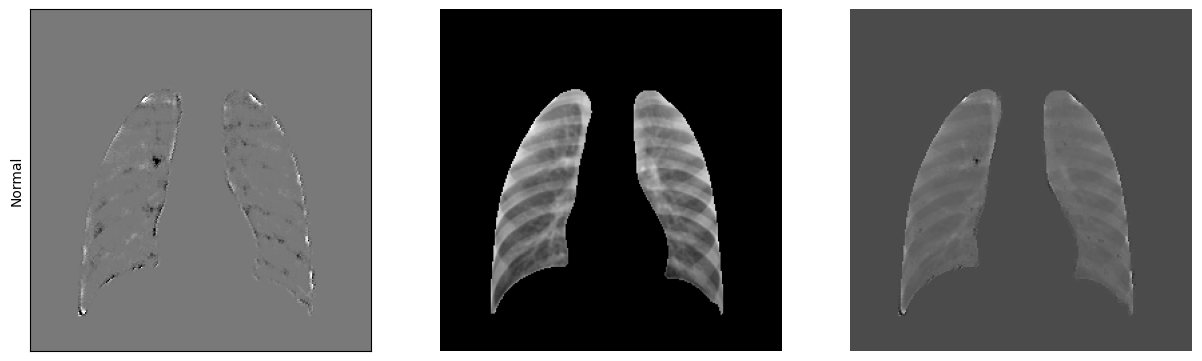

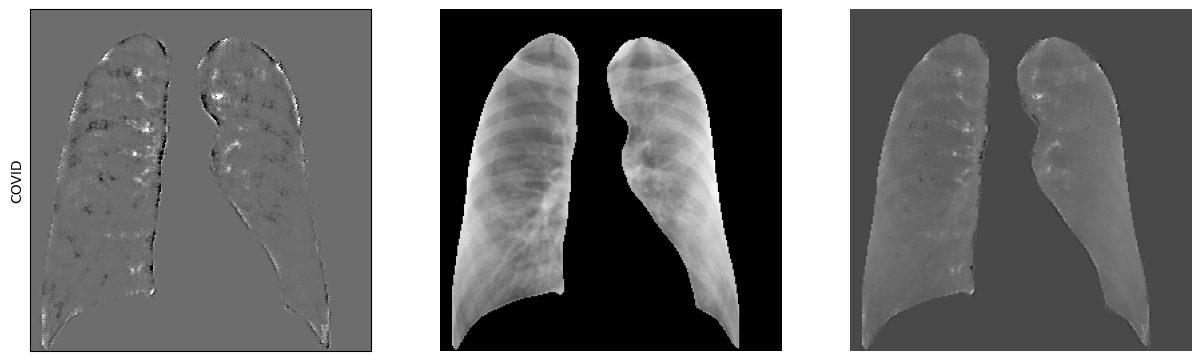

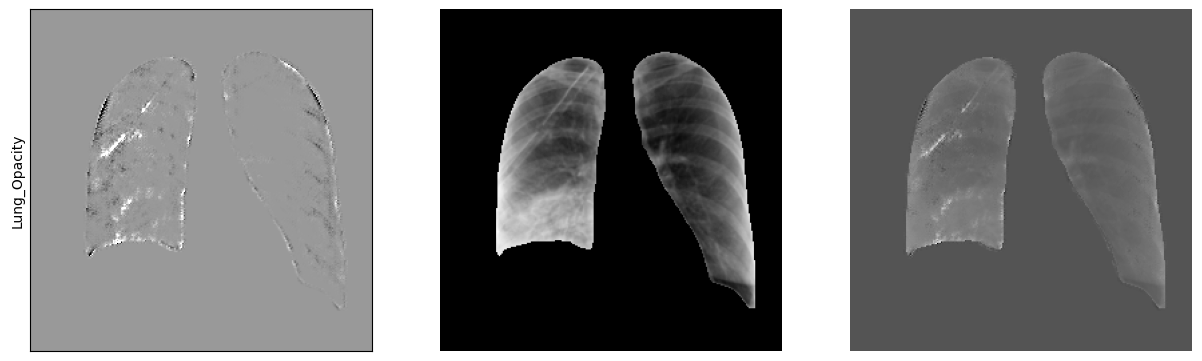

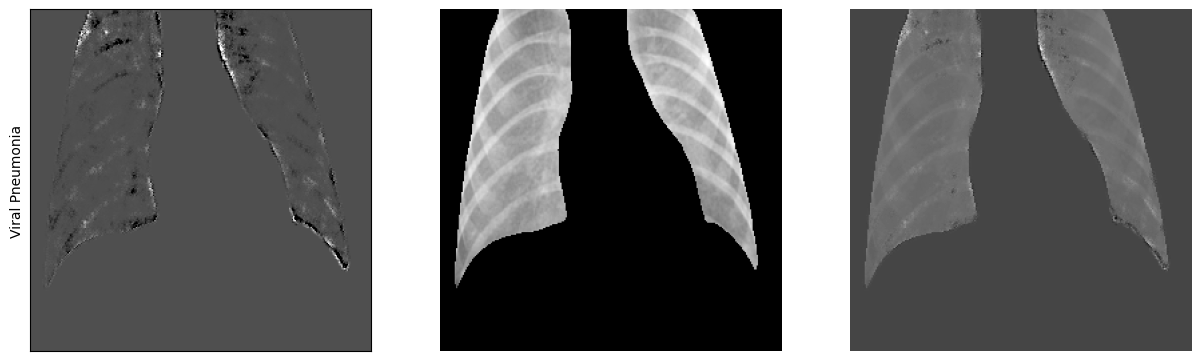

In [4]:
# Which labels shall be included
for l in ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']:
    file, label = pick_random_image(case='roi', label=l)
    input_img = prep_input(file)
    flat_img = norm_flat_image(input_img[0])
    result = model.predict(input_img)
    max_idx = tf.argmax(result,axis = 1)

    # This is the actual calculation of the gradients then
    with tf.GradientTape() as tape:
        tape.watch(input_img)
        result = model(input_img)
        max_score = result[0, max_idx[0]]
    grads = tape.gradient(max_score, input_img)
    
    plot_maps(norm_flat_image(grads[0]), norm_flat_image(input_img[0]), label=label)

## GradCam

### Utility Functions
- find_last_conv_layer: Returns the last layer of a model that is of type "Convolutional" and has a 4d output
- prepare_image: Takes an image filepath and returns the image converted to a RGB space as well as the array with a preprending empty axis, so it can be fed into the models (substitutes the batch_size)
- calculate_heatmap: Calculates the CAM gradients of a model predicting the label of an image. If not specified, the layer will be the last convolutional layer
- create_overlay: Takes a previously calculated heatmap and applies a colormap and resizing such that an overlay of the heatmap with the original image can be shown 

In [5]:

def find_last_conv_layer(model):
    last_conv_layer = None
    for layer in reversed(model.layers):
        if len(layer.get_output_at(0).shape) == 4 and 'conv' in layer._name:
            last_conv_layer = layer
            break
    return last_conv_layer

def prepare_image(img_uri, img_shape=(256, 256)):

    img = Image.open(img_uri)
    img.resize(img_shape)
    return img

def calculate_heatmap(model, image, layer_name=None, debug=False):

    array = img_to_array(image)
    
    if layer_name is None:
        layer = find_last_conv_layer(model)
    else:
        layer = model.get_layer(layer_name)
    'Calculating gradients for model {} at layer {}'.format(model.name, layer.name)
    
    grad_model = Model(
        [model.inputs], [layer.output, model.output]
    )

    with GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(array[newaxis, ...])
        pred_index = argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., newaxis]
    heatmap = squeeze(heatmap)

    if debug:
        return heatmap, (grads, pooled_grads, last_conv_layer_output, pred_index)
    return heatmap

def create_overlay(image, heatmap, alpha_i=1, alpha_h=0.3, debug=True):
    # array = img_to_array(image.convert('RGB'))
    image = image.convert('RGB')
    heatmap = (heatmap-np.min(heatmap))/np.max(heatmap)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = array_to_img(heatmap)
    heatmap = heatmap.resize(image.size)
    heatmap.putalpha(int(256*alpha_h))
    image.putalpha(int(256*alpha_i))
    overlay = Image.alpha_composite(image, heatmap)
    if debug:
        return overlay, (image, heatmap)
    return overlay


In [6]:
base_dir = os.path.abspath('..')
# specifiy the model for which the visualisation shall happen
model = load_model(os.path.join(base_dir, 'models', 'cnn', 'LMAP3_nap', 'LMAP3_nap_roi.keras'))

### Visualisation

/var/folders/_j/9jd214m51l95zvt28tkj3nvh0000gn/T/ipykernel_67897/3528268802.py:48: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


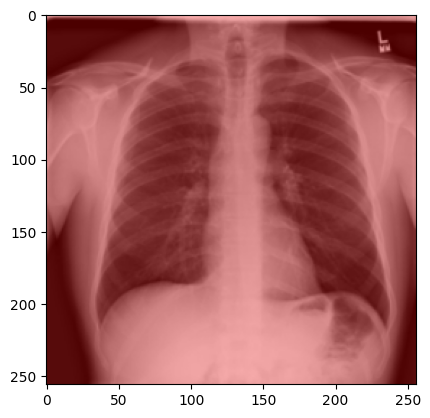

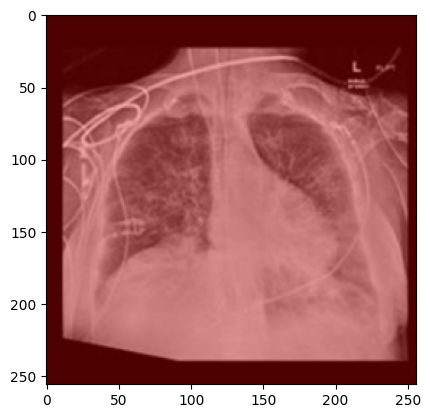

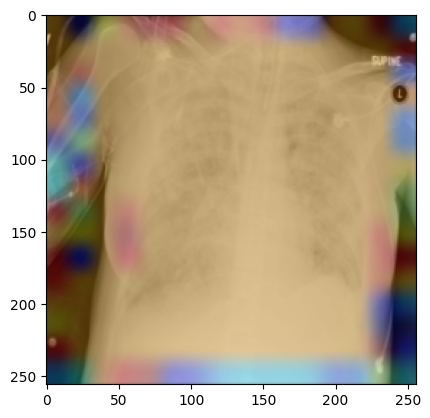

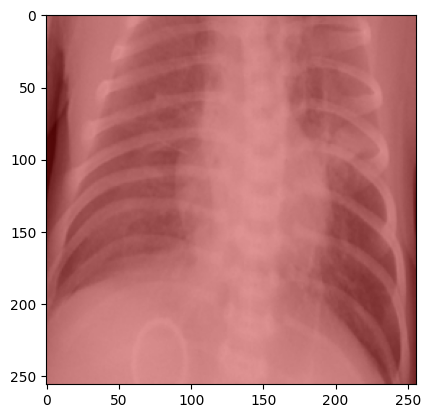

In [7]:
for l in ['Normal', 'COVID', 'Lung_Opacity', 'Viral Pneumonia']:
    file, label = pick_random_image(case='raw', label=l)
    image = prepare_image(file)
    heatmap, _ = calculate_heatmap(model, image, layer_name=None, debug=True)
    overlay, _ = create_overlay(image, heatmap)
    plt.imshow(overlay)
    plt.show()